In [1]:
import numpy as np
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Conv1D, MaxPooling1D
from keras.models import load_model
import os
import tensorflow as tf
import time
import datetime
import csv
import sys, os
sys.path.append(os.pardir)
from createdatas import createdata
from scipy.optimize import curve_fit    # フィッティング用
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE' #意味はわからん

date = str(datetime.date.today())
print(date)

Using TensorFlow backend.


2020-10-28


In [2]:
train_num = 10000 #訓練データの数
test_num = 1000 #テストデータの数
data_size = 100 #配列の大きさ
NOISE = 80

x_train = np.zeros((train_num,data_size))
y_train = np.zeros((train_num,data_size))
t_train = np.zeros((train_num, 3))
ty_train = np.zeros((train_num, 3))
x_test = np.zeros((test_num,data_size))
y_test = np.zeros((test_num,data_size))
t_test = np.zeros((test_num, 3))
ty = np.zeros((test_num, 3))

In [3]:
fit_param_x = np.zeros((train_num, 4))
fit_param_y = np.zeros((train_num, 4))

createdata(train_num, NOISE, data_size, x_train, y_train, t_train, ty_train, fit_param_x, fit_param_y)

経過時間:401.49356389045715[sec]
平均絶対誤差: 0.307708 ± 0.233136


(10000, array([[ 0.39516192,  0.3818672 , -0.33118866, ...,  0.04964033,
         -0.04966113, -0.37880559],
        [-0.08150697,  0.29159598, -0.18101816, ..., -0.06037865,
          0.28344928,  0.08138081],
        [-0.13892976, -0.06941648, -0.24426323, ...,  0.34946405,
          0.16424587,  0.06831508],
        ...,
        [-0.05404285,  0.05867419, -0.13628602, ...,  0.1303962 ,
         -0.15434846,  0.18714369],
        [-0.12493887,  0.35824211,  0.35940528, ..., -0.13637283,
         -0.39924366,  0.20524647],
        [-0.28813748, -0.26165713, -0.33443123, ..., -0.21788693,
          0.00041683, -0.18504212]]), array([[-0.17425717,  0.16839601,  0.148136  , ..., -0.28962646,
         -0.15684193,  0.02462573],
        [-0.30941517, -0.07565977, -0.24430538, ..., -0.2500683 ,
         -0.37282748, -0.15541244],
        [-0.22575552, -0.02279543,  0.04188338, ...,  0.35151864,
          0.32286334, -0.25075841],
        ...,
        [-0.22592401, -0.21078075, -0.16457693, 

In [4]:
fit_param_x = np.zeros((test_num, 4))
fit_param_y = np.zeros((test_num, 4))

createdata(test_num, NOISE, data_size, x_test, y_test, t_test, ty, fit_param_x, fit_param_y)

経過時間:39.589224100112915[sec]
平均絶対誤差: 0.306882 ± 0.237908
[[1.  0.  5. ]
 [1.  0.  5. ]
 [1.  0.  5. ]
 ...
 [1.  1.9 5. ]
 [1.  1.9 5. ]
 [1.  1.9 5. ]]


In [5]:
#訓練データ,テストデータの保存
save_x_train = "/Users/nagaiyuma/Desktop/maindata/"+date+"x_train80%.csv"
save_t_train = "/Users/nagaiyuma/Desktop/maindata/"+date+"t_train80%.csv"
save_x_test = "/Users/nagaiyuma/Desktop/maindata/"+date+"x_test80%.csv"
save_t_test = "/Users/nagaiyuma/Desktop/maindata/"+date+"t_test80%.csv"

with open(save_x_train,'w') as f:
    writer = csv.writer(f)
    writer.writerows(x_train)
with open(save_t_train,'w') as f:
    writer = csv.writer(f)
    writer.writerows(t_train)
with open(save_x_test,'w') as f:
    writer = csv.writer(f)
    writer.writerows(x_test)
with open(save_t_test,'w') as f:
    writer = csv.writer(f)
    writer.writerows(t_test)

In [3]:
#過去の訓練データの読込
data_py_path = "/Users/nagaiyuma/Desktop/maindata/201023/noise80%/2020-10-23"
with open(data_py_path + "x_train.csv") as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    x_train = np.array([row for row in reader])
    
with open(data_py_path + "x_test.csv") as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    x_test = np.array([row for row in reader])
    
with open(data_py_path + "t_train.csv") as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    t_train = np.array([row for row in reader])
    
with open(data_py_path + "t_test.csv") as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    t_test = np.array([row for row in reader])

In [4]:
#まともなCNN3の実装
batch_size = 200  # 訓練データを200ずつのデータに分けて学習させる
epochs = 50 # 訓練データを繰り返し学習させる数

#データ形式の変更(シーケンス長, パラメータ数)
train_x = x_train.reshape(-1, 100, 1)
train_t = t_train
test_x = x_test.reshape(-1, 100, 1)
test_t = t_test

model = Sequential()
model.add(Conv1D(50, 3, padding='same', input_shape=(100, 1), activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(50, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(5, padding='same'))
model.add(Conv1D(10, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(layers.Flatten())
model.add(Dense(100, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(3, activation='relu', kernel_initializer="he_normal"))

model.summary()

model.compile(loss='mse',
 optimizer='adam',
 metrics=['mae'])

history = model.fit(train_x, train_t,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_data=(test_x, test_t))

score = model.evaluate(test_x, test_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#modelの保存
save_model_path = "/Users/nagaiyuma/Desktop/parameters/"+date+"-80%cnn3.h5"
model.save(save_model_path)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 50)           200       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 50)            7550      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 50)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 10)            1510      
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)             

2020-10-28_cnn3_noise80_N1000.png


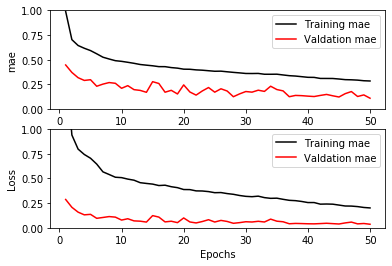

In [6]:
N = 1000
NOISE = 80
#損失関数とmaeの推移
savename = date +"_cnn3_noise%d_N%d.png" % (NOISE, N)
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

print(savename)

plt.subplot(2,1,1)
plt.plot(epochs, mae,  color="black", label = 'Training mae')
plt.plot(epochs, val_mae,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('mae')
plt.ylim(0.0, 1.0)      # y軸の表示範囲
plt.subplot(2,1,2)
plt.plot(epochs, loss,  color="black", label = 'Training mae')
plt.plot(epochs, val_loss,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.savefig(savename) # png画像として出力
plt.show()
plt.close()

In [13]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 

hist_json_file = 'history80_3.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [8]:
abs_error = abs(np.array(model.predict(test_x).T[1].flatten()- t_test.T[1].flatten()))
ave_abs = np.average(abs_error)
std_abs = np.std(abs_error)
error = "平均絶対誤差: %f ± %f" % (ave_abs, std_abs)
print(error)

平均絶対誤差: 0.265142 ± 0.176330


In [9]:
t_train = t_train.T[1].flatten()
t_test = t_test.T[1].flatten()

#まともなCNNの実装
batch_size = 200  # 訓練データを200ずつのデータに分けて学習させる
epochs = 50 # 訓練データを繰り返し学習させる数

#データ形式の変更(シーケンス長, パラメータ数)
train_x = x_train.reshape(-1, 100, 1)
train_t = t_train
test_x = x_test.reshape(-1, 100, 1)
test_t = t_test

model = Sequential()
model.add(Conv1D(50, 3, padding='same', input_shape=(100, 1), activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(50, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(5, padding='same'))
model.add(Conv1D(10, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(layers.Flatten())
model.add(Dense(100, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu', kernel_initializer="he_normal"))

model.summary()

model.compile(loss='mse',
 optimizer='adam',
 metrics=['mae'])

history = model.fit(train_x, train_t,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_data=(test_x, test_t))

score = model.evaluate(test_x, test_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#modelの保存
save_model_path = "/Users/nagaiyuma/Desktop/parameters/"+date+"-80%cnn1.h5"
model.save(save_model_path)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 100, 50)           200       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 50)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 50)            7550      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 50)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 10, 10)            1510      
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

2020-10-28_ccn1_noise80_N1000.png


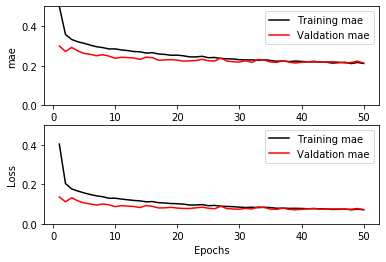

In [10]:
N = 1000
NOISE = 80
#損失関数とmaeの推移
savename = date +"_ccn1_noise%d_N%d.png" % (NOISE, N)
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

print(savename)

plt.subplot(2,1,1)
plt.plot(epochs, mae,  color="black", label = 'Training mae')
plt.plot(epochs, val_mae,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('mae')
plt.ylim(0.0, 0.5)      # y軸の表示範囲
plt.subplot(2,1,2)
plt.plot(epochs, loss,  color="black", label = 'Training mae')
plt.plot(epochs, val_loss,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('Loss')
plt.ylim(0.0, 0.5)
plt.savefig(savename) # png画像として出力
plt.show()
plt.close()

In [15]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 

hist_json_file = 'history80_1.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [12]:
abs_error = abs(np.array(model.predict(test_x).flatten()- t_test))
ave_abs = np.average(abs_error)
std_abs = np.std(abs_error)
error = "平均絶対誤差: %f ± %f" % (ave_abs, std_abs)
print(error)

平均絶対誤差: 0.213559 ± 0.162591
